# Estimating Factor Analysis
One of the simplest model for generative auto-encoders is Factor Analysis. We'll use our method to learn it, with the loss function


$$ \mathcal L(\boldsymbol \theta, y^{(i)})  = {y^{(i)}}^\top \hat y_{\boldsymbol \theta}^{(i)} - \mathbb E_{p_{\boldsymbol\theta}}[y^\top \hat y_{\boldsymbol \theta}]$$

where $\hat y_{\boldsymbol \theta} = \text{decoder}_{\boldsymbol \theta}(\text{encoder}_{\boldsymbol \theta}(y))$ and $y\sim p_{\boldsymbol \theta}$.

The encoder and decoder are optimized separately

In [175]:
import torch
from torch import nn
import numpy as np
import math
import matplotlib.pyplot as plt
import copy

In [176]:
# DIMENSIONS
n = 1000
p = 10
q = 1
DIMENSION_Y = (n, p)
DIMENSION_Z = (n, q)

In [177]:
class FA(nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize Module
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.var_y = torch.ones(p)
        self.encoder_opt = torch.optim.Adam(self.encoder.parameters())

    def forward(self, y):
        with torch.no_grad():
            z = self.encoder(y)
        y = self.decoder(z)
        return y
    
    def sample(self, z = None):
        """Sample from the fitted model."""
        with torch.no_grad():
            if z is None:
                z = torch.randn(DIMENSION_Z)

            eps = torch.randn(DIMENSION_Y) * torch.sqrt(self.var_y)
            y = self.decoder(z) + eps
        
        return (y, z)

    def encoder_fit(self, y, z, epochs=100, verbose=False):
        encoder_loss = nn.MSELoss()
        for epoch in range(epochs):
            self.encoder_opt.zero_grad()

            zhat = self.encoder(y)
            loss = encoder_loss(zhat, z)
            loss.backward()
            self.encoder_opt.step()

            if verbose:
                print("Epoch {} Loss {:.2f}".format(epoch, loss.item()))
        return loss.item()

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Define parameters
        self.w = nn.Parameter(torch.randn(q, p) * .5)
    
    # override forward
    def forward(self, z):
        linpar = z @ self.w
        return linpar


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Define a sequential model
        self.encoder_model = nn.Sequential(
            # nn.Linear(in_features = p, out_features = 100),
            # nn.ReLU(),
            # nn.Linear(in_features = 100, out_features = 100),
            # nn.ReLU(),
            nn.Linear(in_features=p, out_features=q)
        )

    def forward(self, y):
        return self.encoder_model(y)

class GMLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, input, target, input_sim, target_sim):
        loss = - torch.mean(input * target - input_sim * target_sim)
        return loss

In [178]:
model_true = FA()
y_true, z_true = model_true.sample()
assert y_true.shape == DIMENSION_Y and z_true.shape == DIMENSION_Z
model = FA()
loss_fn = GMLoss()
# Fit the model
optimizer = torch.optim.Adam(model.decoder.parameters(), lr =.1)
# Fit eval: MSE
eval_fn = nn.MSELoss()



In [179]:
epochs = 1000
for epoch in range(epochs):
    # Simulate and forward pass on the simulated sample
    y_sim, z_sim = model.sample()

    
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    target_true = model(y_true)
    target_sim = model(y_sim)

    # Compute the loss
    loss = loss_fn(y_true, target_true, y_sim, target_sim)
    loss.backward()
    optimizer.step()
    
    # Train the encoder
    loss_encoder = model.encoder_fit(y_sim, z_sim, epochs=10, verbose=False)

    # Eval the fit every 10 epochs
    if epoch % 10 == 0:
        with torch.no_grad():
            eval = eval_fn(y_true, target_true)
        print("Epoch {} Loss: decoder {:.3f}, encoder {:.3f}".format(epoch, eval, loss_encoder))

Epoch 0 Loss: decoder 1.290, encoder 0.981
Epoch 10 Loss: decoder 1.077, encoder 0.610
Epoch 20 Loss: decoder 0.991, encoder 0.429
Epoch 30 Loss: decoder 0.948, encoder 0.332
Epoch 40 Loss: decoder 0.945, encoder 0.336
Epoch 50 Loss: decoder 0.933, encoder 0.303
Epoch 60 Loss: decoder 0.929, encoder 0.281
Epoch 70 Loss: decoder 0.928, encoder 0.277
Epoch 80 Loss: decoder 0.929, encoder 0.309
Epoch 90 Loss: decoder 0.924, encoder 0.274
Epoch 100 Loss: decoder 0.920, encoder 0.257
Epoch 110 Loss: decoder 0.923, encoder 0.286
Epoch 120 Loss: decoder 0.936, encoder 0.307
Epoch 130 Loss: decoder 0.932, encoder 0.295
Epoch 140 Loss: decoder 0.929, encoder 0.269
Epoch 150 Loss: decoder 0.923, encoder 0.265
Epoch 160 Loss: decoder 0.924, encoder 0.267
Epoch 170 Loss: decoder 0.925, encoder 0.288
Epoch 180 Loss: decoder 0.926, encoder 0.281
Epoch 190 Loss: decoder 0.917, encoder 0.251
Epoch 200 Loss: decoder 0.920, encoder 0.261
Epoch 210 Loss: decoder 0.923, encoder 0.292
Epoch 220 Loss: decod

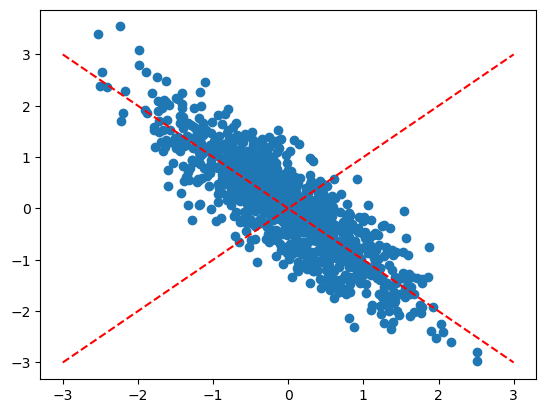

In [180]:
plt.scatter(model.encoder(y_true).detach().numpy(), z_true.detach().numpy())
plt.plot([-3,3], [3,-3], "--", color = "red")
plt.plot([-3,3], [-3,3], "--", color = "red")

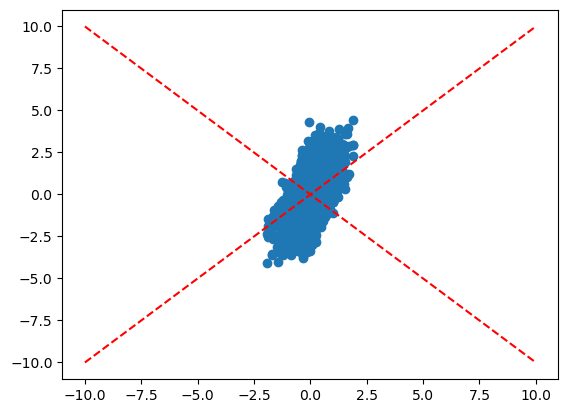

In [181]:
plt.scatter(model(y_true).detach().numpy(), y_true)
plt.plot([-10,10], [10,-10], "--", color = "red")
plt.plot([-10,10], [-10,10], "--", color = "red")